In [120]:
import os
import pandas
import matplotlib.pyplot as plt
import numpy as np

In [121]:
# "LCOE qsf H_rmin P_ref solarm H_tower dni_des H_rec D_rec_tb D_riser D_dcomr tshours dT_chrg dT_htHX dT_ltHX"

pdata = [\
    [\
        "case",
        "inst",
        "iter",
        "lcoe",
        "qsf",
        "receiver_height_min",
        "cycle_design_power",
        "solar_multiple",
        "tower_height",
        "dni_design_point",
        "receiver_height",
        "tube_inner_diam",
        "riser_inner_diam", 
        "downcomer_inner_diam", 
        "hours_tes",
        "dT_approach_charge_hx",
        "dT_approach_ht_disch_hx",
        "dT_approach_lt_disch_hx",
    ]
]

In [122]:
is_normalize = False

In [123]:
for fname in os.listdir(os.getcwd()):
    if "optimization-log" not in fname:
        continue

    # fname = "optimization-log-181_surround-bucket.txt"
    fdata = open(fname, 'r').readlines()

    for line in fdata:
        try:
            strvals = line.replace('\n','').split()
            vals = [float(v) for v in strvals[3:]]
            inst,case = strvals[0].split("_")
            iter = int(strvals[2])
            pdata.append([case, int(inst), iter] + vals)
        except:
            continue

In [124]:
df = pandas.DataFrame(pdata[1:], columns=pdata[0])

In [125]:
if is_normalize:
    df.lcoe /= df.lcoe.min()
    lcoe_label = "LCOE (normalized)"
else:
    lcoe_label = "LCOE (c/kWh)"

In [126]:
cases = list(set(df["case"]))
cases.sort()
iters = list(set(df.iter))

In [127]:
df.iloc[df.groupby(df.case).lcoe.idxmin().values]

case  inst  iter   lcoe      qsf  receiver_height_min  \
1236  surround-skip   100    61  9.096  162.125                4.566   

      cycle_design_power  solar_multiple  tower_height  dni_design_point  \
1236              62.057             2.5         200.0           874.555   

      receiver_height  tube_inner_diam  riser_inner_diam  \
1236            4.536            0.368              0.43   

      downcomer_inner_diam  hours_tes  dT_approach_charge_hx  \
1236                 0.527     11.331                   40.0   

      dT_approach_ht_disch_hx  dT_approach_lt_disch_hx  
1236                   24.691                   12.534

In [128]:
all_lcoes = []

for case in cases:
    dfc = df[df.case == case]
    #print(dfc.iloc[dfc.lcoe.argmin()].values)

    caseinsts = list(set(dfc.inst))
    caselcoes = []

    for inst in caseinsts:
        caselcoes.append(dfc[dfc.inst == inst].lcoe.min())

    all_lcoes.append(caselcoes)


In [129]:
metrics = [\
        "cycle_design_power",
        "solar_multiple",
        "tower_height",
        "dni_design_point",
        "receiver_height",
        "tube_inner_diam",
        "riser_inner_diam", 
        "downcomer_inner_diam", 
        "hours_tes",
        "dT_approach_charge_hx",
        "dT_approach_ht_disch_hx",
        "dT_approach_lt_disch_hx",
        ]

metricsn = [\
    r"Cycle design gross power (MWe)",
    r"Solar multiple (-)", 
    r"Tower height (m)",
    r"Design-point DNI (W/m2)",
    r"Receiver absorber height (m)",
    r"Tube inner diameter (m)",
    r"Riser pipe $\Phi$-inner (m)",
    r"Down-comer pipe $\Phi$-inner (m)",
    r"Hours full-load storage (hr)",
    r"Charge HX approach temp. ($^\circ$C)",
    r"HT Discharge HX approach temp. ($^\circ$C)",
    r"LT Discharge HX approach temp. ($^\circ$C)",
]

In [130]:
y_quants = [df.lcoe.min()*.95, df.lcoe.quantile(0.98)]

<Figure size 432x288 with 0 Axes>

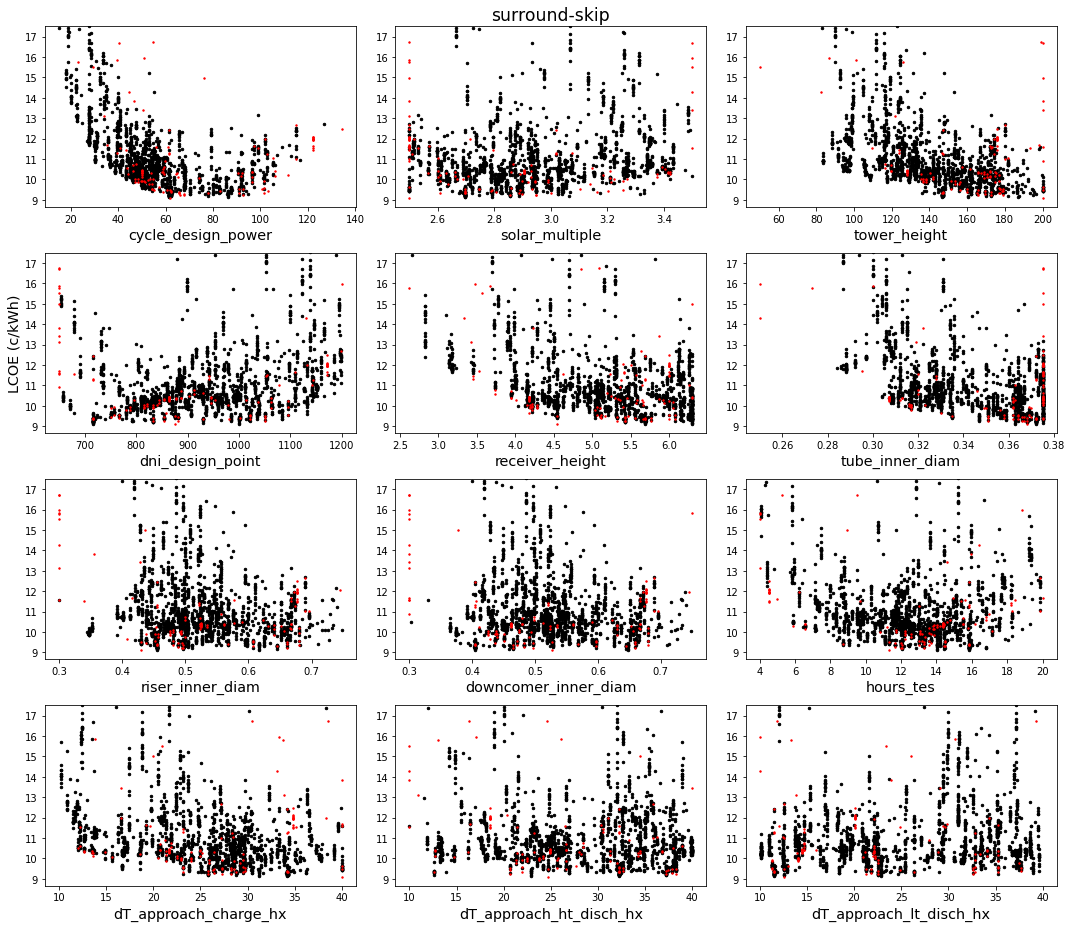

In [131]:
for case in cases:
    dfc = df[df.case == case][df.receiver_height >= df.receiver_height_min]
    dfci = df[df.case == case][df.receiver_height < df.receiver_height_min]

    plt.clf()

    plt.subplots(4, 3, sharey=True, squeeze=True, figsize=(15,13))
    
    for mi,metric in enumerate(metrics):

        ax = plt.subplot(4,3,mi+1)
        ax.scatter(x=dfc[metric].values, y=dfc.lcoe.values, c='k', s=6)
        ax.scatter(x=dfci[metric].values, y=dfci.lcoe.values, c='r', s=2)

        ax.set_ylim(0.95 * dfc.lcoe.min(), y_quants[1])

        plt.xlabel(metric, fontsize='x-large')

        if mi == 1:
            plt.title(case, fontsize='xx-large')
        if mi == 3:
            plt.ylabel(lcoe_label, fontsize = 'x-large')
    
    plt.tight_layout()
    plt.savefig(case + ".png", dpi=250)


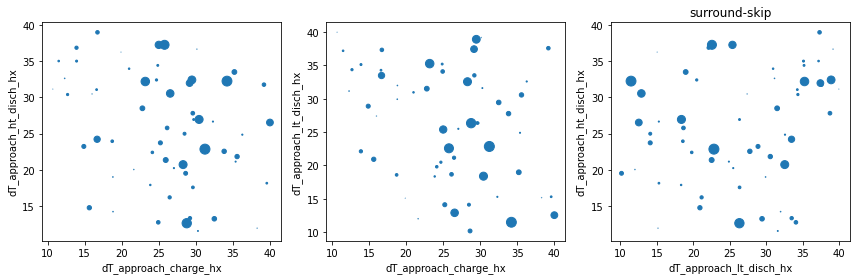

In [132]:
for case in cases:
    dfc = df[df.case == case][df.receiver_height >= df.receiver_height_min]

    opt_locs = []
    for ind in dfc.groupby(dfc.inst).lcoe.idxmin().values:
        if ind == ind:
            opt_locs.append(int(ind))

    dfs_opt = df.iloc[opt_locs]

    f,axs = plt.subplots(1,3, figsize=(12,4))
    if is_normalize:
        pxsize = 10
        pxmin = 0.3
    else:
        pxsize = 100
        pxmin = 1

    dfs_opt.plot.scatter(x='dT_approach_charge_hx', y='dT_approach_ht_disch_hx', style='ko', s=pxsize/((dfs_opt.lcoe.values - dfs_opt.lcoe.min() + pxmin)**3), ax=axs[0])
    dfs_opt.plot.scatter(x='dT_approach_charge_hx', y='dT_approach_lt_disch_hx', style='ko', s=pxsize/((dfs_opt.lcoe.values - dfs_opt.lcoe.min() + pxmin)**3), ax=axs[1])
    dfs_opt.plot.scatter(x='dT_approach_lt_disch_hx', y='dT_approach_ht_disch_hx', style='ko', s=pxsize/((dfs_opt.lcoe.values - dfs_opt.lcoe.min() + pxmin)**3), ax=axs[2])

    plt.title(case)
    plt.tight_layout()

    plt.savefig(case+"_dt-hx-tradeoff.png", dpi=250)


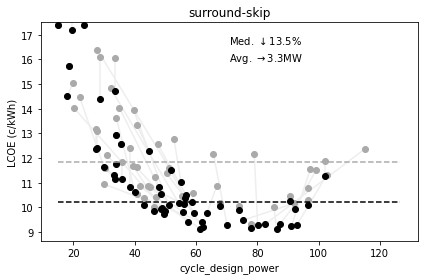

In [133]:
for case in cases:
    dfc = df[df.case == case][df.receiver_height >= df.receiver_height_min]

    case_insts = dfc.groupby(dfc.inst)

    opt_locs = []
    for ind in case_insts.lcoe.idxmin().values:
        if ind == ind:
            opt_locs.append(int(ind))

    dfs_opt = df.iloc[opt_locs]

    start_locs = []
    for ind in case_insts.iter.idxmin().values:
        if ind == ind:
            start_locs.append(int(ind))

    dfs_start = df.iloc[start_locs]

    

    x_start = dfs_start["cycle_design_power"].values
    y_start = dfs_start.lcoe.values
    x_opt = dfs_opt["cycle_design_power"].values
    y_opt = dfs_opt.lcoe.values
    xpairs = [pair for pair in zip(x_start, x_opt)]
    ypairs = [pair for pair in zip(y_start, y_opt)]

    plt.clf()
    ax = plt.gca()


    for p in range(len(xpairs)):
        ax.plot(xpairs[p], ypairs[p], linestyle='-', color="#EEE")
    
    ax.plot(dfs_start.cycle_design_power.values, dfs_start.lcoe.values, marker='o', linestyle='', c='#AAA')
    ax.plot(dfs_opt.cycle_design_power.values, dfs_opt.lcoe.values, marker='o', linestyle='', c='black')

    cmn = dfc.cycle_design_power.min()
    cmx = dfc.cycle_design_power.max()
    lst = dfs_start.lcoe.median()
    lop = dfs_opt.lcoe.median()
    ax.plot([cmn, cmx], [lst, lst], marker='', linestyle='--', c='#AAA')
    ax.plot([cmn, cmx], [lop, lop], marker='', linestyle='--', c='black')
    ax.set_ylim(y_quants[0], y_quants[1])

    cmid = (cmn + cmx)/2.
    ax.text(cmid, y_quants[1]*0.95, r"Med. $\downarrow${:.1f}%".format((lst-lop)/lst*100))
    shift = dfs_start.cycle_design_power.mean() - dfs_opt.cycle_design_power.mean()
    ax.text(cmid, y_quants[1]*0.91, r"Avg. $\{:s}arrow${:.1f}MW".format("left" if shift>0 else "right", abs(shift)))

    plt.title(case)
    plt.ylabel(lcoe_label)
    plt.xlabel("cycle_design_power")
    plt.tight_layout()
    plt.savefig(case + "_movement.png", dpi=250)

In [134]:
# Faster than is_pareto_efficient_simple, but less readable.
def pareto_points(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    else:
        return is_efficient

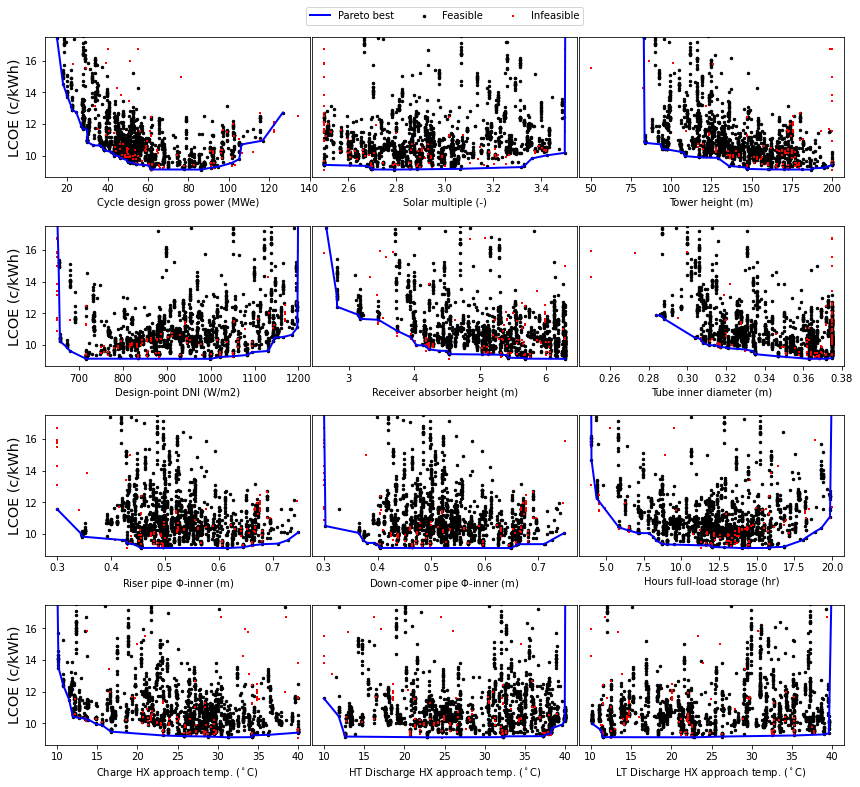

In [148]:
plt.subplots(4, 3, sharey=True, squeeze=True, figsize=(12,11))

p_cycle_save = []

for mi,metric in enumerate(metrics):

    ax = plt.subplot(4,3,mi+1)

    for ci,case in enumerate(cases):
        dfc = df[df.case == case][df.receiver_height >= df.receiver_height_min]
        dfci = df[df.case == case][df.receiver_height < df.receiver_height_min]

        dfch = dfc[dfc.lcoe == dfc.lcoe]

        pdata = np.array(list(zip(dfch[metric].values, dfch.lcoe.values)))
        rpdata = np.array(list(zip(-1*dfch[metric].values, dfch.lcoe.values)))
        p_indices = np.concatenate( (pareto_points(pdata), pareto_points(rpdata) ) )

        if mi == 0:
            p_cycle_save += list(p_indices)

        xdat = dfch.iloc[p_indices][metric].values
        ydat = dfch.iloc[p_indices].lcoe.values
        sdat = list(zip(xdat, ydat))
        sdat.sort()
        xdat, ydat = list(zip(*sdat))
        
        ax.scatter(x=dfc[metric].values, y=dfc.lcoe.values, c='k', s=6, label='Feasible')
        ax.scatter(x=dfci[metric].values, y=dfci.lcoe.values, c='r', s=3, marker='+', label='Infeasible')
        
        ax.plot(xdat, ydat, ms=8, c='b', linestyle='-', linewidth=2, marker=None, label='Pareto best')
        
        ax.set_ylim(y_quants)

        if mi not in [0,3,6,9]:
            ax.set_yticks([])
            ax.set_yticklabels([])
        
        if case == cases[-1]:
            plt.xlabel(metricsn[mi])

            if mi == 1:
            #     plt.title(case, fontsize='xx-large')
                plt.legend(bbox_to_anchor=(0.5, 1.25), loc='upper center', ncol=4)
            if mi % 3 == 0:
                plt.ylabel(lcoe_label, fontsize = 'x-large')
    
plt.tight_layout()
plt.subplots_adjust(hspace=0.35, wspace=0.005)
plt.savefig("pareto-all.png", dpi=300)

In [136]:
# # pareto_file = "cycle-power-pareto-points.csv"
# # df.iloc[p_cycle_save].to_csv(pareto_file)
# # pardf = pandas.read_csv(pareto_file)

# pardf = df.iloc[p_cycle_save]

In [137]:
# pareto_cases = list(set(pardf.case.values))
# pareto_cases.sort()

In [138]:
# # o	the breakout of optimized HEX costs as a function of power scale for the best performing unit
# # o	Riser Cost as a function of power scale for the best performing unit
# # o	Down-Comer Cost as a function of power scale for the best performing unit
# # o	Site Improvement Cost as a function of power scale for the best performing unit

# plot_cols = ['Charge HX cost', 'Discharge (hot) HX cost', 'Discharge (cold) HX cost', 'Riser cost', 'Downcomer cost', 'Site improvement']


# for case in pareto_cases:
#     pardf_case = pardf[pardf.case == case]
#     pardf_case = pardf_case[pardf_case["LCOE (real)"] > 0]

#     plt.clf()

#     plt.subplots(2, 3, figsize=(10,6))

#     cycle_power_vals = pardf_case.cycle_design_power.values

#     for ci,col in enumerate(plot_cols):
#         ax = plt.subplot(2,3,ci+1)

#         yvals = pardf_case[col].values

#         #poly fit
#         coefs = np.polyfit(cycle_power_vals, yvals, 2)
#         f_regr = np.poly1d(coefs)

#         ax.scatter(cycle_power_vals, yvals)

#         xregr = np.arange(pardf_case.cycle_design_power.min(), pardf_case.cycle_design_power.max(), 1)
#         ax.plot(xregr, f_regr(xregr), linestyle='--', color='gray')

#         xmin,xmax = ax.get_xlim() # pardf_case.cycle_design_power.min(), pardf_case.cycle_design_power.max()
#         ymin,ymax = ax.get_ylim() #min(yvals), max(yvals)

#         p=plt.Rectangle((xmin+(xmax-xmin)*0.50, ymin+(ymax-ymin)*.01), (xmax-xmin)*0.5, (ymax-ymin)*0.23, alpha=0.7, facecolor='white', edgecolor='gray', lw=1)
#         ax.add_patch(p)

#         ax.text( xmin+(xmax-xmin)*0.52, ymin+ (ymax-ymin)*0.02, 
#                     "y={:.3e}x$^2$ +\n     {:.3e}x +\n     {:.3e}".format(*coefs), fontsize='small')

#         ax.set_xlabel("Cycle design power (MWe)")
#         ax.set_ylabel(col)
    
#         # if ci==1:
#         #     ax.text(pardf_case.cycle_design_power.median(), max(yvals)*1.2, case, fontsize='xx-large')
#     plt.gcf().suptitle(case, y=1.02, fontsize='x-large')
#     # plt.subplots_adjust(left=0.1, right=0.98, top=.92, bottom=0.15, wspace=0.25, hspace=0.3)
#     plt.tight_layout()
#     plt.savefig(case + ".png", dpi=300, bbox_inches='tight')

